<a href="https://colab.research.google.com/github/MuhammadIrzam447/MultiModel/blob/master/Train_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install rarfile
# import rarfile

# # Path to the .rar file
# rar_file_path = "/content/multi_model-images-train.rar"

# # Extract the contents of the .rar file
# with rarfile.RarFile(rar_file_path, 'r') as rar:
#     rar.extractall("/content/Dataset(s)/")  # Specify the destination folder where you want to extract the files

# print("Extraction complete.")

In [ ]:
# Fused Ferramenta

In [ ]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


# Loading Training Dataset and Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class TrainingDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()
        self.num_classes = len(self.dataset.classes)

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def __len__(self):
        return len(self.dataset)

    def get_num_classes(self):
        return self.num_classes

In [ ]:
data_dir = "/content/Dataset(s)/fused-ferramenta-train"
dataset = TrainingDataset(data_dir)

In [ ]:
print("Number of samples:", len(dataset))
print("Number of classes:", len(dataset.classes))

Number of samples: 66141
Number of classes: 52


In [ ]:
batch_size = 32
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# EDA

In [ ]:
class_lengths_dict = dataset.class_lengths
total_sum = sum(class_lengths_dict.values())
dict_length = len(class_lengths_dict)

# Print the length
print("Dictionary length:", dict_length)
# Print the total sum
print("Total sum:", total_sum)
print(class_lengths_dict.values())

Dictionary length: 52
Total sum: 66141
dict_values([195, 5654, 1041, 150, 404, 533, 3209, 471, 1991, 1936, 422, 106, 345, 2526, 4679, 119, 163, 627, 176, 136, 98, 5792, 858, 1929, 819, 588, 1368, 2111, 2093, 452, 260, 1010, 180, 3606, 222, 459, 726, 444, 430, 987, 620, 1571, 482, 4075, 768, 134, 243, 359, 1144, 487, 331, 6612])


In [ ]:
# Extract class labels and counts from the dictionary
class_labels = list(class_lengths_dict.keys())
class_counts = list(class_lengths_dict.values())

# Create a count plot
plt.figure(figsize=(4, 5))
sns.barplot(x=class_labels, y=class_counts)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Count of Instances in Each Class')
plt.show()

# Loading ResNet-101

In [ ]:
num_classes = dataset.get_num_classes()
print("Number of classes:", num_classes)

Number of classes: 52


In [ ]:
resnet = torchvision.models.resnet101(pretrained=True)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)  # num_classes is the number of classes in your dataset
resnet.to(device)
print(resnet)

# Fine Tuning

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
num_epochs = 20

In [21]:
training_loss = []

for epoch in range(num_epochs):
    # Set the model to training mode
    resnet.train()
    running_loss = 0.0

    # Iterate over the data loader
    for images, labels in data_loader:
        # Move the images and labels to the GPU if available
        images = images.to(device)
        labels = labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item() * images.size(0)

    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(data_loader.dataset)
    training_loss.append(epoch_loss)
    # Print the epoch loss
    print(f"Epoch {epoch+1}/{num_epochs} Training Loss: {epoch_loss:.4f}")


    save_dir = "/content/Model/Models-Train-05/"
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

    model_name = str(epoch+1) + "_model.pth"
    save_path = os.path.join(save_dir, model_name)  # Specify the complete path to the model file
    torch.save(resnet.state_dict(), save_path)

Epoch 1/20 Training Loss: 0.7587
Epoch 2/20 Training Loss: 0.2488
Epoch 3/20 Training Loss: 0.1526
Epoch 4/20 Training Loss: 0.1017
Epoch 5/20 Training Loss: 0.0694
Epoch 6/20 Training Loss: 0.0498
Epoch 7/20 Training Loss: 0.0374
Epoch 8/20 Training Loss: 0.0297
Epoch 9/20 Training Loss: 0.0241
Epoch 10/20 Training Loss: 0.0190
Epoch 11/20 Training Loss: 0.0153
Epoch 12/20 Training Loss: 0.0115
Epoch 13/20 Training Loss: 0.0107
Epoch 14/20 Training Loss: 0.0080
Epoch 15/20 Training Loss: 0.0082
Epoch 16/20 Training Loss: 0.0064
Epoch 17/20 Training Loss: 0.0047
Epoch 18/20 Training Loss: 0.0042
Epoch 19/20 Training Loss: 0.0040
Epoch 20/20 Training Loss: 0.0037


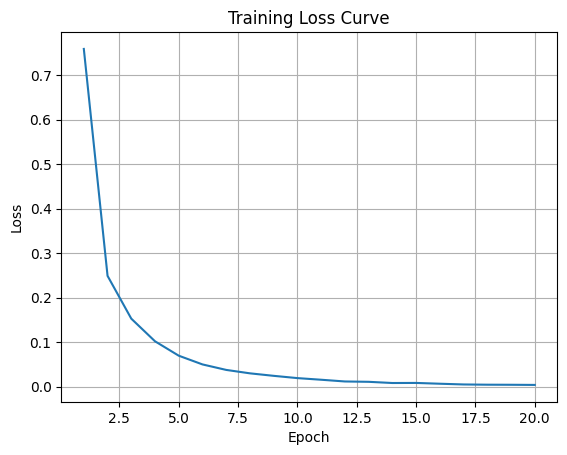

In [22]:
# Plot the loss curve
plt.plot(range(1, num_epochs+1), training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

# Save Best Model File to Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/Models

In [ ]:
# !cp 7_model.pth /content/drive/MyDrive/filename